In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


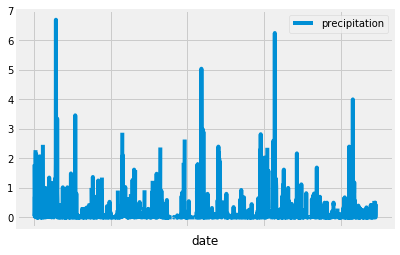

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
total_stations=session.query(Measurement.station).group_by(Measurement.station).count()
total_stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station). \
order_by(func.count(Measurement.station).desc()).all()
active_stations

[(u'USC00519281', 2772),
 (u'USC00519397', 2724),
 (u'USC00513117', 2709),
 (u'USC00519523', 2669),
 (u'USC00516128', 2612),
 (u'USC00514830', 2202),
 (u'USC00511918', 1979),
 (u'USC00517948', 1372),
 (u'USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs),
      func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]

avg_temp=session.query(*sel).group_by(Measurement.station). \
order_by(func.count(Measurement.station).desc()).first()

avg_temp

(u'USC00519281', 54.0, 85.0, 71.66378066378067)

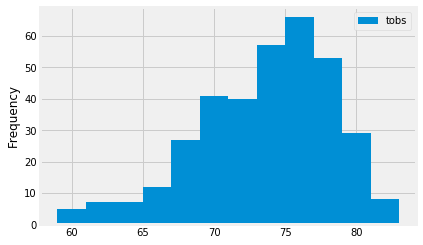

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station=avg_temp[0]

last12mo_top_station=session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station==top_station).\
filter(Measurement.date>=prev_year).\
order_by(Measurement.date).all()

df_top_station_tobs_last12mo=pd.DataFrame(last12mo_top_station,columns=['date','tobs'])

df_top_station_tobs_last12mo.plot.hist(bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2016-08-23', '2016-08-30')
trip_results

[(71.0, 78.11538461538461, 84.0)]

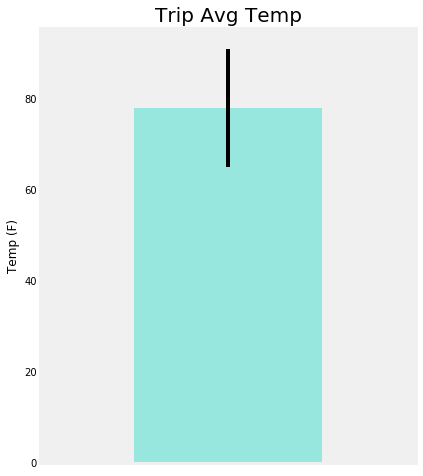

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='turquoise')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()

In [37]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_leave_year = dt.date(2017, 8, 30) - dt.timedelta(days=365)

vacation= session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= prev_year).\
    filter(Measurement.date <= prev_leave_year).\
    order_by(Measurement.station).all()

vacation_df=pd.DataFrame(vacation)

rain_per_station = pd.pivot_table(vacation_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

,prcp
station,
USC00513117,2.90
USC00514830,2.55
USC00516128,5.28
USC00517948,0.06
USC00519281,5.08
USC00519397,0.17
USC00519523,1.59


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
